# Задача 3. Классификация рака молочной железы

***

|---------------------------------------|------------------------------------------------------------------------------------|
| __Набор данных__                      | Breast Cancer Wisconsin (Diagnostic)                                               | 
| __Предварительная обработка__         | масштабирование, разделение данных на обучающие и тестовые                         |
| __Модели__                            | логистическая регрессия, SVM, решающие деревья, случайный лес, градиентный бустинг |
| __Сравнение моделей__                 | точность, матрица ошибок, ROC-кривые                                               |
| __Изучение и подбор гиперпараметров__ | GridSearchCV или RandomizedSearchCV                                                |
| __Визуализация__                      | важности признаков, корреляционная матрица                                         |

## Загрузка датасета

Загрузим набор данных Breast Cancer Wisconsin

In [41]:
import pandas as pd
from pandas import read_csv

dataset: pd.DataFrame = read_csv('data.csv')
dataset.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

## Предварительная обработка

Удаляем ненужные столбцы и избавляемся от нечислового столбца диагноза (2 возможных значения - запишем как 0 и 1)

In [42]:
dataset = dataset.drop(columns=['id', 'Unnamed: 32'])

dataset['diagnosis'] = dataset['diagnosis'].map({'M': 1, 'B': 0})

## Предобработка

Разделение на признаки и целевую переменную, разделение на обучающую и тестовую выборки

In [43]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=['diagnosis'])
y = dataset['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Масштабирование (стандартизация) признаков

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Моделирование

Определение моделей

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

Обучение и сравнение моделей

In [62]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score


metrics = {"Accuracy": accuracy_score, "Precision": precision_score, "Recall": recall_score, "F1-score": f1_score, "ROC AUC": roc_auc_score}
results = {metric: {} for metric in metrics.keys()}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    for metric_name, metric_func in metrics.items():
        if metric_name == "ROC AUC":
            results[metric_name][name] = metric_func(y_test, y_prob)
        else:
            results[metric_name][name] = metric_func(y_test, y_pred)

results_df = pd.DataFrame(results)
print(results_df)

                     Accuracy  Precision    Recall  F1-score   ROC AUC
Logistic Regression  0.973684   0.976190  0.953488  0.964706  0.997380
SVM                  0.982456   1.000000  0.953488  0.976190  0.997380
Decision Tree        0.947368   0.930233  0.930233  0.930233  0.943990
Random Forest        0.964912   0.975610  0.930233  0.952381  0.994759
Gradient Boosting    0.956140   0.952381  0.930233  0.941176  0.995087


### Матрица ошибок

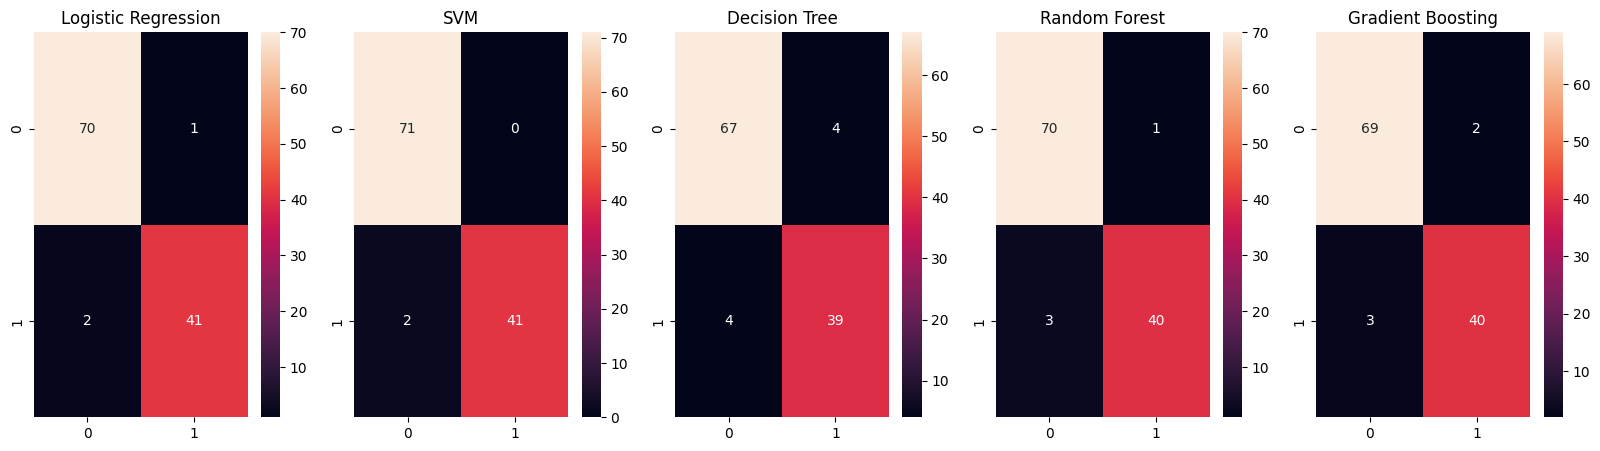

In [58]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
    axes[i].set_title(name)

plt.show()

### ROC-кривые

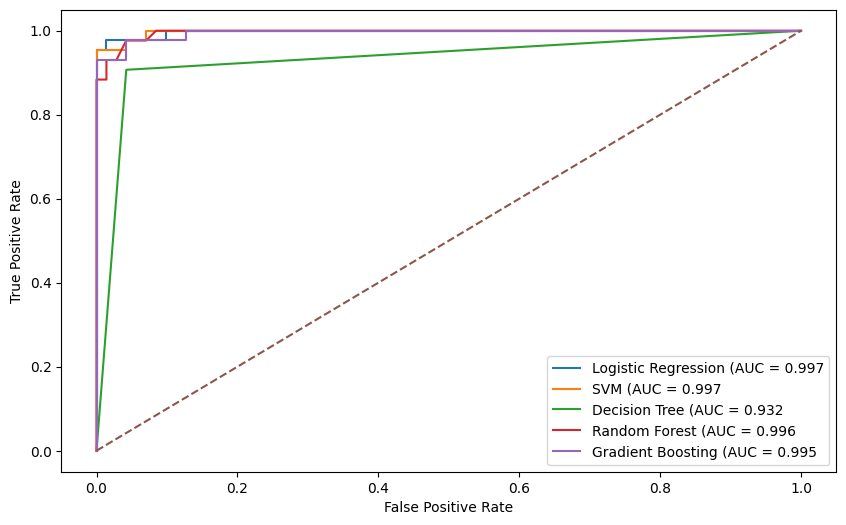

In [53]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Изучение и подбор гиперпараметров

### GridSearchCV

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Лучшие параметры для Random Forest:", grid_search.best_params_)

Лучшие параметры для Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


## Визуализация

### Важность признаков

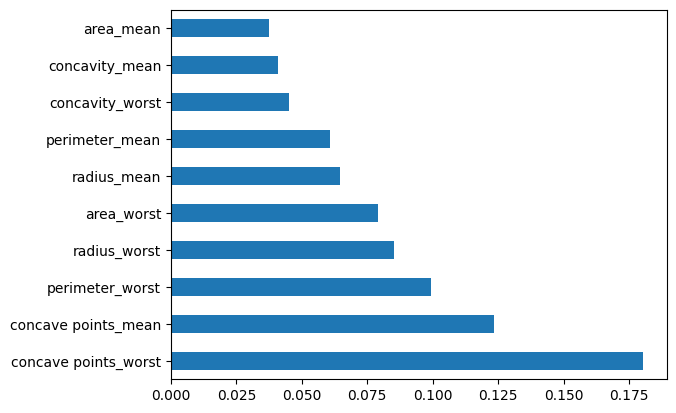

In [50]:
feature_importance = pd.Series(models['Random Forest'].feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

### Матрица корреляции

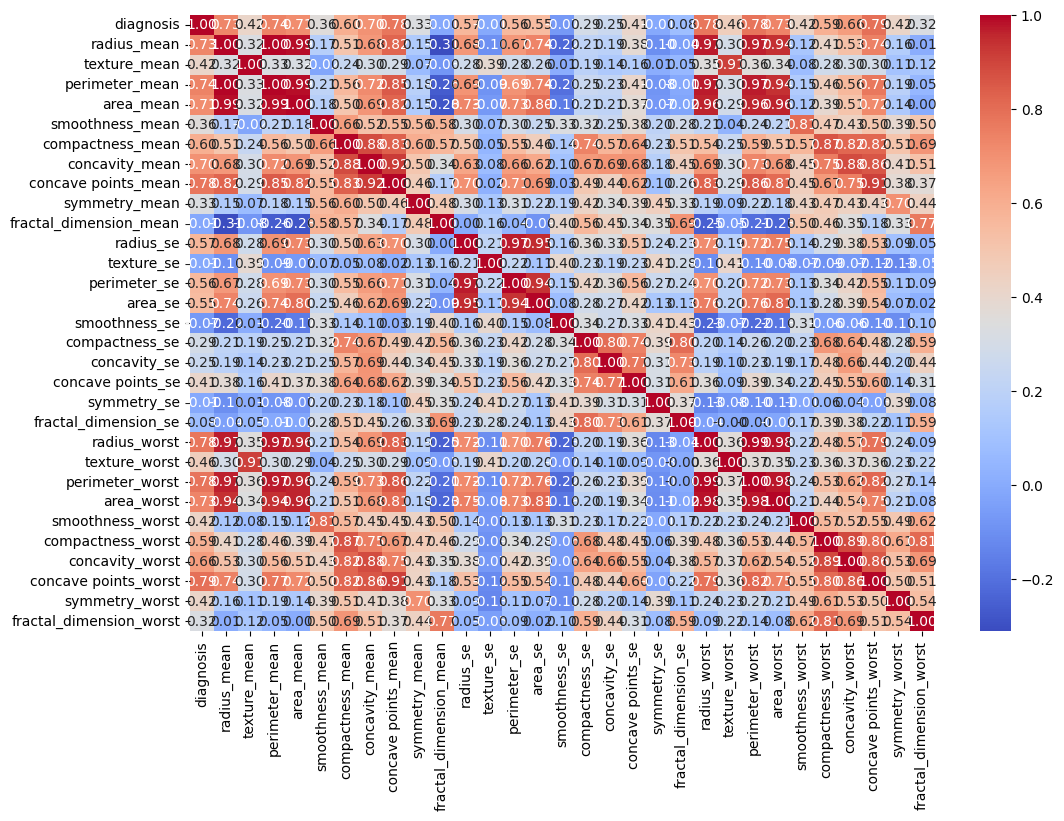

In [51]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()